In [35]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [36]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

,nclients,interfere journal,isolated journal
0,1.0,360.0,191.0
1,5.0,522.0,320.0
2,10.0,985.0,689.0
3,15.0,1412.0,1099.0
4,18.0,1636.0,1282.0


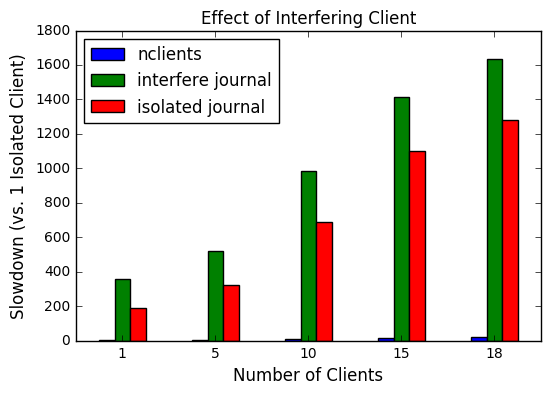

In [37]:
norm = np.mean(parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients1-nolog/*isolated*")))
mean = pd.DataFrame(columns=["nclients", "interfere journal", "isolated journal"])
stds = pd.DataFrame(columns=["nclients", "interfere journal", "isolated journal"])
clients = [1, 5, 10, 15, 18]
for i in clients:
    j0 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*interfere*"))
    j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*isolated*"))    
    mean.loc[len(mean)] = [i, np.max(j0), np.max(j1)]
    stds.loc[len(stds)] = [i, np.std(j0), np.std(j1)]    
fig, ax = plt.subplots(1, 1)
mean.plot.bar(ax=ax)
ax.set_ylabel("Slowdown (vs. 1 Isolated Client)", fontsize=12)
ax.set_title("Effect of Interfering Client", fontsize=12)
ax.set_xlabel("Number of Clients", fontsize=12)
x = ax.set_xticklabels(clients, rotation=0)
mean

,job,nfiles,# of Clients,time,runtime,runtime_norm
5,merge,100000,5,16:02:17,66.715897,4.706524
4,merge,100000,10,15:56:29,122.810551,5.450672
3,merge,100000,15,15:49:49,177.392359,6.096843
2,merge,100000,20,15:42:09,234.260624,5.368664
1,merge,100000,25,15:33:37,289.897085,4.338321
0,merge,100000,30,15:24:26,344.023538,3.655758


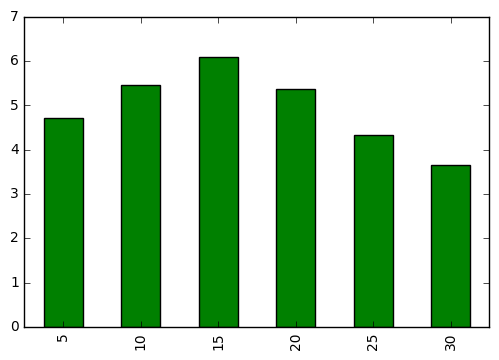

In [38]:
norm = np.mean(parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients1-nolog/*isolated*")))
mean = pd.DataFrame(columns=["nclients", "interfere journal", "isolated journal"])
stds = pd.DataFrame(columns=["nclients", "interfere journal", "isolated journal"])
clients = [30, 25, 20, 15, 10, 5, 1]
for i in clients:
    if i > 15:
        j0 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients18/*interfere*"))
        j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients18/*isolated*"))            
    else:
        j0 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*interfere*"))
        j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*isolated*"))
    mean.loc[len(mean)] = [i, np.mean(j0), np.mean(j1)]
    stds.loc[len(stds)] = [i, np.std(j0), np.std(j1)]    
####

# get the performance
df = pd.read_csv("../results/summary.txt", names=['job', 'nfiles', '# of Clients', 'time', 'runtime'])
df['runtime'] = df['runtime'].apply(to_seconds)

# add on the time to create
with open('../../cudele-mechanisms/results/summary.txt') as f:
    df_create = pd.read_csv(f, names=['job', 'nfiles', 'time', 'runtime'])
    df_create['runtime'] = df_create['runtime'].apply(to_seconds)

# filter
df_create = df_create[df_create['job'] == 'create']
df_create = df_create[df_create['nfiles'] == 100000]

# normalize
df['runtime_norm'] = mean['isolated journal']/df['runtime']
df = df.iloc[::-1]

# drop 1 client
df = df[df['# of Clients'] != 1]

fig, ax = plt.subplots(1, 1)
df['runtime_norm'].plot.bar(ax=ax, color='green')
ax.set_xticklabels(df['# of Clients'])
df

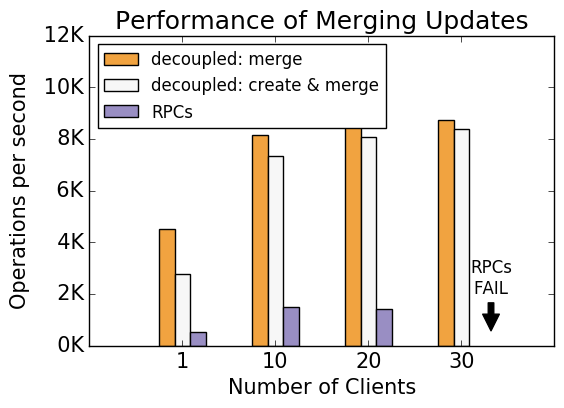

In [63]:
norm = np.mean(parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients1-nolog/*isolated*")))
mean = pd.DataFrame(columns=["nclients", "interfere journal", "isolated journal"])
clients = [30, 25, 20, 15, 10, 5, 1]
for i in clients:
    if i == 20:
        j0 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients18/*interfere*"))
        j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients18/*isolated*"))         
        norm = 18*100000
    elif i > 15:
        j0 = 0
        j1 = 0        
        norm = 18*100000        
    else:
        j0 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*interfere*"))
        j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*isolated*"))
        norm = i*100000        
    mean.loc[len(mean)] = [i, norm/np.mean(j0), norm/np.mean(j1)]

# get the performance
df = pd.read_csv("../results/summary.txt", names=['job', 'nfiles', '# of Clients', 'time', 'runtime'])
df['runtime'] = df['runtime'].apply(to_seconds)
df['RPCs (interfere)'] = mean['interfere journal']
df['RPCs'] = mean['isolated journal']
del df['job'], df['nfiles'], df['time']

# get the thruput of decoupled
df['decoupled: merge'] = (df['# of Clients']*100000)/df['runtime']
df
df = df.iloc[::-1]
#df = df[df['# of Clients'] > 1]

# add on the time to create
with open('../../cudele-mechanisms/results/summary.txt') as f:
    df_create = pd.read_csv(f, names=['job', 'nfiles', 'time', 'runtime'])
    df_create['runtime'] = df_create['runtime'].apply(to_seconds)
df_create = df_create[df_create['job'] == 'create']
df_create = df_create[df_create['nfiles'] == 100000]
df['Merge+Create'] = (df['# of Clients']*100000)/(df['runtime']+float(df_create['runtime']))
df['decoupled: create & merge'] = (df['# of Clients']*100000)/(df['runtime']+float(df_create['runtime']+(2.727+1.155+1.157)))

df = df[df['# of Clients'] != 5]
df = df[df['# of Clients'] != 15]
df = df[df['# of Clients'] != 25]

font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, y=['decoupled: merge',  'decoupled: create & merge', 'RPCs'], colors=['#f1a340', '#f7f7f7', '#998ec3'])

ax.set_xticklabels(df['# of Clients'], rotation=0)
ax.set_ylabel("Operations per second")
ax.legend(loc='upper left', fontsize=12)
ax.annotate('RPCs\nFAIL', xy=(3.32, 500), xytext=(3.32, 2000),horizontalalignment='center', fontsize=12, arrowprops=dict(facecolor='black', shrink=0.05))
#ax.annotate('FAIL', xy=(6.3, 500), xytext=(6.3, 2000),horizontalalignment='center', arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_xlabel("Number of Clients")
ax.set_xlim(-1, 4)
ax.set_ylim(0, 12000)
ax.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()])
ax.set_title("Performance of Merging Updates")
fig.savefig('graphs/mergescale.png', bbox_inches='tight', dpi=400)